In [ ]:
# %%

import matplotlib.pyplot as plt
import pyro
import seaborn as sns
import torch
from pyro.infer.mcmc import HMC, MCMC
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


# depends on your network connection,
# it make take more than a few mintues
mnist = fetch_openml("mnist_784")

x_train, x_test, y_train, y_test = train_test_split(
    mnist.data,
    mnist.target,
    test_size=0.2,
    random_state=2020,
)

d:\SAIT\aDATA475\VS_Python\lab7p\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\SAIT\aDATA475\VS_Python\lab7p\.venv\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
# %%

# create a DecisionTreeClassifier object and fit with training data
clf_dt = DecisionTreeClassifier()
clf_dt.fit(x_train, y_train)

DecisionTreeClassifier()

In [ ]:
# %%

# create a LogisticRegression object and fit with training data
clf_lr = LogisticRegression(max_iter=200)
clf_lr.fit(x_train, y_train)

d:\SAIT\aDATA475\VS_Python\lab7p\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200)

In [ ]:
# %%

# get prediction label using clf_dt and print the accuracy score
y_pred_dt = clf_dt.predict(x_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", accuracy_dt)

Decision Tree Accuracy: 0.8701428571428571


In [ ]:
# %%

# get prediction label using clf_lr and print the accuracy score
y_pred_lr = clf_lr.predict(x_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy:", accuracy_lr)

Logistic Regression Accuracy: 0.9123571428571429


In [ ]:
# %%

# label to be used in Monte Carlo method
y_dt = torch.Tensor(y_pred_dt == y_test)
y_lr = torch.Tensor(y_pred_lr == y_test)

In [ ]:
# %%

def model():
    # create a variable underlying_p for the Bernoulli distribution
    # where underlying_p is a sample of Uniform distribution from 0 to 1
    underlying_p = pyro.sample("p", pyro.distributions.Uniform(0, 1))
    
    # create a hidden Bernoulli distribution with p = underlying_p
    y_hidden_dist = pyro.distributions.Bernoulli(underlying_p)
    
    # sample the label from the hidden Bernoulli distribution
    y_real = pyro.sample("obs", y_hidden_dist)
    return y_real


def conditioned_model(model, y):
    conditioned_model_function = pyro.poutine.condition(
        model, data={"obs": y}
    )
    return conditioned_model_function()


def monte_carlo(y):
    pyro.clear_param_store()

    # create a Simple Hamiltonian Monte Carlo kernel with step_size of 0.1
    hmc_kernel = HMC(conditioned_model, step_size=0.1)

    # create a Markov Chain Monte Carlo method with:
    # the hmc_kernel, 500 samples, and 100 warmup iterations
    mcmc = MCMC(hmc_kernel, num_samples=500, warmup_steps=100)

    mcmc.run(model, y)

    sample_dict = mcmc.get_samples(num_samples=5000)
    plt.figure(figsize=(8, 6))
    sns.distplot(sample_dict["p"].numpy())
    plt.xlabel("Observed probability value")
    plt.ylabel("Observed frequency")
    plt.show()
    mcmc.summary(prob=0.95)

    return sample_dict

Sample: 100%|██████████| 600/600 [00:56, 10.66it/s, step size=1.96e+00, acc. prob=0.762] 
<ipython-input-7-d7e3074d74cb>:36: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_dict["p"].numpy())


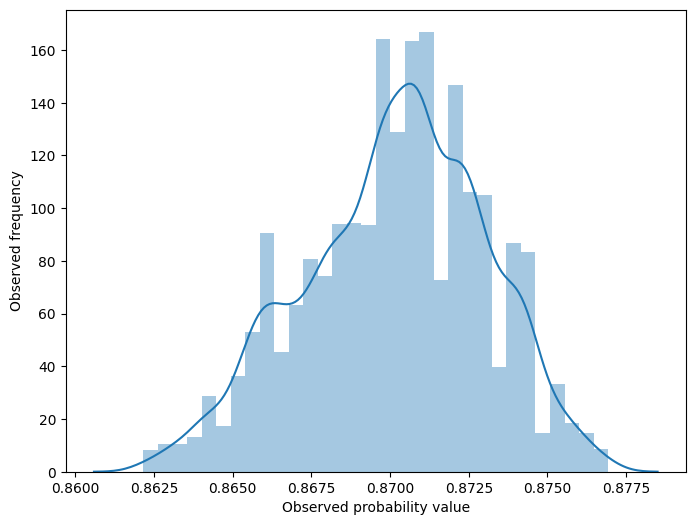


                mean       std    median      2.5%     97.5%     n_eff     r_hat
         p      0.87      0.00      0.87      0.86      0.87    136.97      1.00

Number of divergences: 0


In [ ]:
# %%

# run the Monte Carlo method with y_dt and save the sample_dict with name simulations_dt
simulations_dt = monte_carlo(y_dt)

Sample: 100%|██████████| 600/600 [00:46, 12.89it/s, step size=7.65e-01, acc. prob=0.986]
<ipython-input-7-d7e3074d74cb>:36: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_dict["p"].numpy())


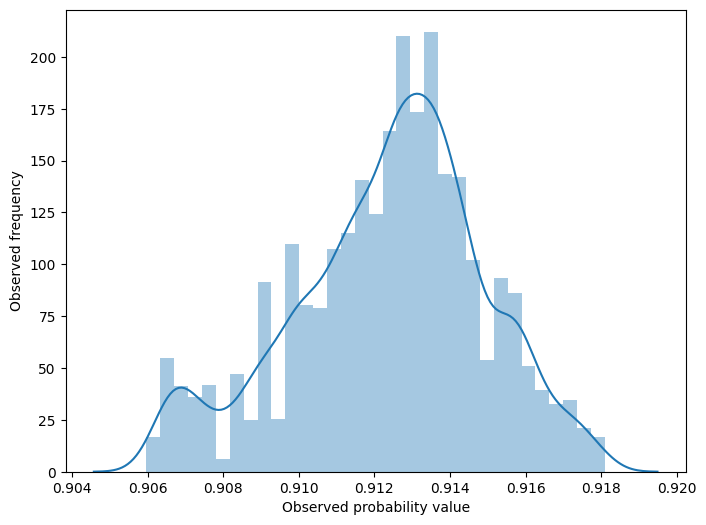


                mean       std    median      2.5%     97.5%     n_eff     r_hat
         p      0.91      0.00      0.91      0.91      0.92     12.13      1.05

Number of divergences: 0


In [ ]:
#%%

# run the Monte Carlo method with y_lr and save the sample_dict with name simulations_lr
simulations_lr = monte_carlo(y_lr)

<ipython-input-10-b047048a5698>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
<ipython-input-10-b047048a5698>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


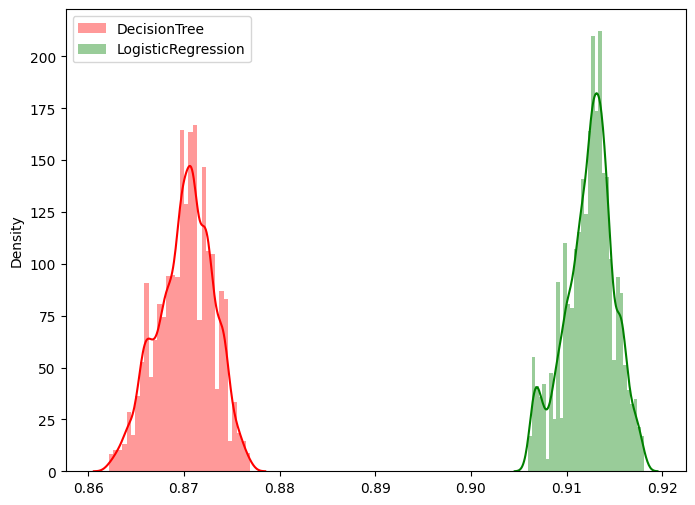

In [ ]:
# %%

plt.figure(figsize=(8, 6))
sns.distplot(
    simulations_dt["p"].numpy(),
    label="DecisionTree",
    color="red",
)
sns.distplot(
    simulations_lr["p"].numpy(),
    label="LogisticRegression",
    color="green",
)
plt.legend()
plt.show()